In [2]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt

from pylab import rcParams
rcParams['pdf.fonttype']=42
rcParams['font.sans-serif'] = "Arial"
rcParams['font.family'] = "sans-serif"
rcParams['font.size']=10


In [3]:
def LLS_function(list_of_pairs,reference_file,delim=',',mingenes=5,maxgenes=400,binsize=1000,maxbins=50, debug=False):
    #
    # initialize reference matrix as dict
    #
    reference_interaction_matrix = {}
    reference_genelist_dict = {}
    #
    # populate reference interaction matrix from reference file
    #
    ref_file=open(reference_file, 'r')
    #
    # also test read of gene pair file before the processing starts
    #
    pairs_file = open(list_of_pairs, 'r')
    #
    #
    for ref_line in ref_file:
        #
        # format: term ID, source, list of genes
        #
        genelist = ref_line.rstrip().split('\t')[2:]   # skip the first two elements
        numGenes = len(genelist)
        if ( (numGenes < mingenes) | (numGenes > maxgenes) ):
            #
            # failed size check for this annotation
            # return control to top of loop, skipping further processing 
            #
            continue
            # 
        #
        # add every gene pair ot the reference matrix
        #
        #print('.',end='')
        for i in range(numGenes-1):
            g1 = genelist[i]
            
            reference_genelist_dict[g1]=1
            
            if ( g1 not in reference_interaction_matrix.keys() ):
                reference_interaction_matrix[g1] = {}
            
            for j in range(i+1,numGenes):
            
                g2 = genelist[j]

                reference_genelist_dict[g2]=1
                
                if ( g2 not in reference_interaction_matrix.keys() ):
                    reference_interaction_matrix[g2] = {}
                
                reference_interaction_matrix[g1][g2]=1
                reference_interaction_matrix[g2][g1]=1
    #
    # how many interactions in the reference 
    #
    # first, get the list of all genes
    reference_genelist = sorted( reference_genelist_dict.keys() )
    num_genes_in_reference = len(reference_genelist)
    #
    # then, systematically go through and see how many pairs are ints. for loops!
    #
    numPosInts = 0
    numNegInts = 0
    #
    for i in range(num_genes_in_reference-1):
            g1 = reference_genelist[i]
            for j in range(i+1,num_genes_in_reference):
                g2 = reference_genelist[j]
                if ( g2 in reference_interaction_matrix[g1].keys() ):  # python dictionary trick
                    numPosInts = numPosInts + 1
                else:
                    numNegInts = numNegInts + 1
    background_lr = np.log2(numPosInts/numNegInts)
    if (debug):
        print( 'Reference files:       {0:s}'.format( reference_file ) )
        print( 'Positive interactions: {0:d}'.format(numPosInts) )
        print( 'Negative interactions: {0:d}'.format(numNegInts) )
        print( 'Background log ratio:  {0:4.3f}'.format( background_lr ) )
        print( )
    ref_file.close()
    #
    # now read the pairs file, line by line,
    # keep a running count of line number, sumPos, sumNeg
    #
    linecount = 0
    sumPos = 0
    sumNeg = 0
    gene_list=[]
    lls_output_df = pd.DataFrame(columns=['LLS','Ratio','numPos','numNeg','numUniqGenes'])
    for gene_pairs_line in pairs_file:
        #
        # format: g1, g2, score
        #
        g1, g2 = gene_pairs_line.rstrip().split(delim)[:2]   # only use first two elements
        gene_list.append(g1)
        gene_list.append(g2) 
        linecount = linecount + 1
        if ( (g1 in reference_genelist_dict.keys() ) & ( g2 in reference_genelist_dict.keys() ) ):
            # g1 and g2 both in reference set. score this as either positive or negative.
            if ( g1 in reference_interaction_matrix[g2].keys() ):
                sumPos += 1
            else:
                sumNeg += 1
        
        #
        # have we filled a bin?
        #
        if (linecount % binsize == 0):
            if ( (sumPos > 0) & (sumNeg > 0) ):
                ratio = sumPos / sumNeg
                lls = np.log2(ratio) - background_lr
            else:
                lls = 0
                ratio = 0
            unique_genes=len(list(set(gene_list)))
            lls_output_df.loc[linecount] = [lls, ratio, sumPos, sumNeg, unique_genes]
        if (linecount > binsize * maxbins):
            break
    return lls_output_df

In [3]:
# LOCAL
def LLS_function_local(list_of_pairs,reference_file,delim=',',mingenes=5,maxgenes=400,binsize=1000,maxbins=50, debug=False):
    #
    # initialize reference matrix as dict
    #
    reference_interaction_matrix = {}
    reference_genelist_dict = {}
    #
    # populate reference interaction matrix from reference file
    #
    ref_file=open(reference_file, 'r')
    #
    # also test read of gene pair file before the processing starts
    #
    pairs_file = open(list_of_pairs, 'r')
    #
    #
    for ref_line in ref_file:
        #
        # format: term ID, source, list of genes
        #
        genelist = ref_line.rstrip().split('\t')[2:]   # skip the first two elements
        numGenes = len(genelist)
        if ( (numGenes < mingenes) | (numGenes > maxgenes) ):
            #
            # failed size check for this annotation
            # return control to top of loop, skipping further processing 
            #
            continue
            # 
        #
        # add every gene pair ot the reference matrix
        #
        #print('.',end='')
        for i in range(numGenes-1):
            g1 = genelist[i]
            
            reference_genelist_dict[g1]=1
            
            if ( g1 not in reference_interaction_matrix.keys() ):
                reference_interaction_matrix[g1] = {}
            
            for j in range(i+1,numGenes):
            
                g2 = genelist[j]

                reference_genelist_dict[g2]=1
                
                if ( g2 not in reference_interaction_matrix.keys() ):
                    reference_interaction_matrix[g2] = {}
                
                reference_interaction_matrix[g1][g2]=1
                reference_interaction_matrix[g2][g1]=1
    #
    # how many interactions in the reference 
    #
    # first, get the list of all genes
    reference_genelist = sorted( reference_genelist_dict.keys() )
    num_genes_in_reference = len(reference_genelist)
    #
    # then, systematically go through and see how many pairs are ints. for loops!
    #
    numPosInts = 0
    numNegInts = 0
    #
    for i in range(num_genes_in_reference-1):
            g1 = reference_genelist[i]
            for j in range(i+1,num_genes_in_reference):
                g2 = reference_genelist[j]
                if ( g2 in reference_interaction_matrix[g1].keys() ):  # python dictionary trick
                    numPosInts = numPosInts + 1
                else:
                    numNegInts = numNegInts + 1
    background_lr = np.log2(numPosInts/numNegInts)
    if (debug):
        print( 'Reference files:       {0:s}'.format( reference_file ) )
        print( 'Positive interactions: {0:d}'.format(numPosInts) )
        print( 'Negative interactions: {0:d}'.format(numNegInts) )
        print( 'Background log ratio:  {0:4.3f}'.format( background_lr ) )
        print( )
    ref_file.close()
    #
    # now read the pairs file, line by line,
    # keep a running count of line number, sumPos, sumNeg
    #
    linecount = 0
    sumPos = 0
    sumNeg = 0
    lls_output_df = pd.DataFrame(columns=['LLS','Ratio','numPos','numNeg'])
    for gene_pairs_line in pairs_file:
        #
        # format: g1, g2, score
        #
        g1, g2 = gene_pairs_line.rstrip().split(delim)[:2]   # only use first two elements
        linecount = linecount + 1
        if ( (g1 in reference_genelist_dict.keys() ) & ( g2 in reference_genelist_dict.keys() ) ):
            # g1 and g2 both in reference set. score this as either positive or negative.
            if ( g1 in reference_interaction_matrix[g2].keys() ):
                sumPos += 1
            else:
                sumNeg += 1
        
        #
        # have we filled a bin?
        #
        if (linecount % binsize == 0):
            if ( (sumPos > 0) & (sumNeg > 0) ):
                ratio = sumPos / sumNeg
                lls = np.log2(ratio) - background_lr
                lls_output_df.loc[linecount] = [lls, ratio, sumPos, sumNeg]
                sumNeg=0
                sumPos=0
            else:
                lls = 0
                ratio=0

        if (linecount > binsize * maxbins):
            break
    return lls_output_df

In [ ]:
# FULL REACTOME CUMULATIVE AND LOCAL 

In [ ]:
# FULL Reactome only min 5 max 400 CERES LOCAL

Reactome_LLS_50k_C_White_PCC_local=LLS_function_local("Ceres_Whitened_PCC_100k.csv","c2.cp.reactome.v7.5.1.symbols.gmt",mingenes=5,maxgenes=400)
Reactome_LLS_50k_C_Chol_PCC_local=LLS_function_local("Ceres_Nonorm_Chol_PCC_abs_top100kpairs.csv","c2.cp.reactome.v7.5.1.symbols.gmt",mingenes=5,maxgenes=400)
Reactome_LLS_50k_C_Qnorm_PCC_local=LLS_function_local("Ceres_Qnorm_NoChol_PCC_abs_top100kpairs.csv","c2.cp.reactome.v7.5.1.symbols.gmt",mingenes=5,maxgenes=400)
Reactome_LLS_50k_C_Boyle_PCC_local=LLS_function_local("Ceres_Boyle_NoChol_PCC_abs_top100kpairs.csv","c2.cp.reactome.v7.5.1.symbols.gmt",mingenes=5,maxgenes=400)
Reactome_LLS_50k_C_PCC_local=LLS_function_local("Ceres_Nonorm_NoChol_PCC_abs_top100kpairs.csv","c2.cp.reactome.v7.5.1.symbols.gmt",mingenes=5,maxgenes=400)
Reactome_LLS_50k_C_Qnorm_Chol_PCC_local=LLS_function_local("Ceres_Qnorm_Chol_PCC_abs_top100kpairs.csv","c2.cp.reactome.v7.5.1.symbols.gmt",mingenes=5,maxgenes=400)
Reactome_LLS_50k_C_Boyle_Chol_PCC_local=LLS_function_local("Ceres_Boyle_Chol_PCC_abs_top100kpairs.csv","c2.cp.reactome.v7.5.1.symbols.gmt",mingenes=5,maxgenes=400)

# FULL Reactome only min 5 max 400 ZSCORES LOCAL

Reactome_LLS_50k_Z_White_PCC_local=LLS_function_local("Z_Whitened_PCC_100k.csv","c2.cp.reactome.v7.5.1.symbols.gmt",mingenes=5,maxgenes=400)
Reactome_LLS_50k_Z_Chol_PCC_local=LLS_function_local("Zscores_Nonorm_Chol_PCC_abs_top100kpairs.csv","c2.cp.reactome.v7.5.1.symbols.gmt",mingenes=5,maxgenes=400)
Reactome_LLS_50k_Z_Qnorm_PCC_local=LLS_function_local("Zscores_Qnorm_NoChol_PCC_abs_top100kpairs.csv","c2.cp.reactome.v7.5.1.symbols.gmt",mingenes=5,maxgenes=400)
Reactome_LLS_50k_Z_Boyle_PCC_local=LLS_function_local("Zscores_Boyle_NoChol_PCC_abs_top100kpairs.csv","c2.cp.reactome.v7.5.1.symbols.gmt",mingenes=5,maxgenes=400)
Reactome_LLS_50k_Z_PCC_local=LLS_function_local("Zscores_Nonorm_NoChol_PCC_abs_top100kpairs.csv","c2.cp.reactome.v7.5.1.symbols.gmt",mingenes=5,maxgenes=400)
Reactome_LLS_50k_Z_Qnorm_Chol_PCC_local=LLS_function_local("Zscores_Qnorm_Chol_PCC_abs_top100kpairs.csv","c2.cp.reactome.v7.5.1.symbols.gmt",mingenes=5,maxgenes=400)
Reactome_LLS_50k_Z_Boyle_Chol_PCC_local=LLS_function_local("Zscores_Boyle_Chol_PCC_abs_top100kpairs.csv","c2.cp.reactome.v7.5.1.symbols.gmt",mingenes=5,maxgenes=400)

# FULL Reactome only min 5 max 400 BF LOCAL

Reactome_LLS_50k_BF_White_PCC_local=LLS_function_local("BF_Whitened_PCC_100k.csv","c2.cp.reactome.v7.5.1.symbols.gmt",mingenes=5,maxgenes=400)
Reactome_LLS_50k_BF_Chol_PCC_local=LLS_function_local("BF_Nonorm_Chol_PCC_abs_top100kpairs.csv","c2.cp.reactome.v7.5.1.symbols.gmt",mingenes=5,maxgenes=400)
Reactome_LLS_50k_BF_Qnorm_PCC_local=LLS_function_local("BF_Qnorm_NoChol_PCC_abs_top100kpairs.csv","c2.cp.reactome.v7.5.1.symbols.gmt",mingenes=5,maxgenes=400)
Reactome_LLS_50k_BF_Boyle_PCC_local=LLS_function_local("BF_Boyle_NoChol_PCC_abs_top100kpairs.csv","c2.cp.reactome.v7.5.1.symbols.gmt",mingenes=5,maxgenes=400)
Reactome_LLS_50k_BF_PCC_local=LLS_function_local("BF_Nonorm_NoChol_PCC_abs_top100kpairs.csv","c2.cp.reactome.v7.5.1.symbols.gmt",mingenes=5,maxgenes=400)
Reactome_LLS_50k_BF_Qnorm_Chol_PCC_local=LLS_function_local("BF_Qnorm_Chol_PCC_abs_top100kpairs.csv","c2.cp.reactome.v7.5.1.symbols.gmt",mingenes=5,maxgenes=400)
Reactome_LLS_50k_BF_Boyle_Chol_PCC_local=LLS_function_local("BF_Boyle_Chol_PCC_abs_top100kpairs.csv","c2.cp.reactome.v7.5.1.symbols.gmt",mingenes=5,maxgenes=400)

# FULL Reactome only min 5 max 400 Chronos LOCAL

Reactome_LLS_50k_CH_White_PCC_local=LLS_function_local("Chronos_Whitened_PCC_100k.csv","c2.cp.reactome.v7.5.1.symbols.gmt",mingenes=5,maxgenes=400)
Reactome_LLS_50k_CH_Chol_PCC_local=LLS_function_local("Chronos_Nonorm_Chol_PCC_abs_top100kpairs.csv","c2.cp.reactome.v7.5.1.symbols.gmt",mingenes=5,maxgenes=400)
Reactome_LLS_50k_CH_Qnorm_PCC_local=LLS_function_local("Chronos_Qnorm_NoChol_PCC_abs_top100kpairs.csv","c2.cp.reactome.v7.5.1.symbols.gmt",mingenes=5,maxgenes=400)
Reactome_LLS_50k_CH_Boyle_PCC_local=LLS_function_local("Chronos_Boyle_NoChol_PCC_abs_top100kpairs.csv","c2.cp.reactome.v7.5.1.symbols.gmt",mingenes=5,maxgenes=400)
Reactome_LLS_50k_CH_PCC_local=LLS_function_local("Chronos_Nonorm_NoChol_PCC_abs_top100kpairs.csv","c2.cp.reactome.v7.5.1.symbols.gmt",mingenes=5,maxgenes=400)
Reactome_LLS_50k_CH_Qnorm_Chol_PCC_local=LLS_function_local("Chronos_Qnorm_Chol_PCC_abs_top100kpairs.csv","c2.cp.reactome.v7.5.1.symbols.gmt",mingenes=5,maxgenes=400)
Reactome_LLS_50k_CH_Boyle_Chol_PCC_local=LLS_function_local("Chronos_Boyle_Chol_PCC_abs_top100kpairs.csv","c2.cp.reactome.v7.5.1.symbols.gmt",mingenes=5,maxgenes=400)


In [ ]:
# FULL Reactome min 5 max 400 Chronos

Reactome_LLS_50k_CH_White_PCC=LLS_function("Chronos_Whitened_PCC_100k.csv","c2.cp.reactome.v7.5.1.symbols.gmt",mingenes=5,maxgenes=400)
Reactome_LLS_50k_CH_Chol_PCC=LLS_function("Chronos_Nonorm_Chol_PCC_abs_top100kpairs.csv","c2.cp.reactome.v7.5.1.symbols.gmt",mingenes=5,maxgenes=400)
Reactome_LLS_50k_CH_Qnorm_PCC=LLS_function("Chronos_Qnorm_NoChol_PCC_abs_top100kpairs.csv","c2.cp.reactome.v7.5.1.symbols.gmt",mingenes=5,maxgenes=400)
Reactome_LLS_50k_CH_Boyle_PCC=LLS_function("Chronos_Boyle_NoChol_PCC_abs_top100kpairs.csv","c2.cp.reactome.v7.5.1.symbols.gmt",mingenes=5,maxgenes=400)
Reactome_LLS_50k_CH_PCC=LLS_function("Chronos_Nonorm_NoChol_PCC_abs_top100kpairs.csv","c2.cp.reactome.v7.5.1.symbols.gmt",mingenes=5,maxgenes=400)
Reactome_LLS_50k_CH_Qnorm_Chol_PCC=LLS_function("Chronos_Qnorm_Chol_PCC_abs_top100kpairs.csv","c2.cp.reactome.v7.5.1.symbols.gmt",mingenes=5,maxgenes=400)
Reactome_LLS_50k_CH_Boyle_Chol_PCC=LLS_function("Chronos_Boyle_Chol_PCC_abs_top100kpairs.csv","c2.cp.reactome.v7.5.1.symbols.gmt",mingenes=5,maxgenes=400)

# FULL Reactome only min 5 max 400 CERES

Reactome_LLS_50k_C_White_PCC=LLS_function("Ceres_Whitened_PCC_100k.csv","c2.cp.reactome.v7.5.1.symbols.gmt",mingenes=5,maxgenes=400)
Reactome_LLS_50k_C_Chol_PCC=LLS_function("Ceres_Nonorm_Chol_PCC_abs_top100kpairs.csv","c2.cp.reactome.v7.5.1.symbols.gmt",mingenes=5,maxgenes=400)
Reactome_LLS_50k_C_Qnorm_PCC=LLS_function("Ceres_Qnorm_NoChol_PCC_abs_top100kpairs.csv","c2.cp.reactome.v7.5.1.symbols.gmt",mingenes=5,maxgenes=400)
Reactome_LLS_50k_C_Boyle_PCC=LLS_function("Ceres_Boyle_NoChol_PCC_abs_top100kpairs.csv","c2.cp.reactome.v7.5.1.symbols.gmt",mingenes=5,maxgenes=400)
Reactome_LLS_50k_C_PCC=LLS_function("Ceres_Nonorm_NoChol_PCC_abs_top100kpairs.csv","c2.cp.reactome.v7.5.1.symbols.gmt",mingenes=5,maxgenes=400)
Reactome_LLS_50k_C_Qnorm_Chol_PCC=LLS_function("Ceres_Qnorm_Chol_PCC_abs_top100kpairs.csv","c2.cp.reactome.v7.5.1.symbols.gmt",mingenes=5,maxgenes=400)
Reactome_LLS_50k_C_Boyle_Chol_PCC=LLS_function("Ceres_Boyle_Chol_PCC_abs_top100kpairs.csv","c2.cp.reactome.v7.5.1.symbols.gmt",mingenes=5,maxgenes=400)

# FULL Reactome only min 5 max 400 ZSCORES

Reactome_LLS_50k_Z_White_PCC=LLS_function("Z_Whitened_PCC_100k.csv","c2.cp.reactome.v7.5.1.symbols.gmt",mingenes=5,maxgenes=400)
Reactome_LLS_50k_Z_Chol_PCC=LLS_function("Zscores_Nonorm_Chol_PCC_abs_top100kpairs.csv","c2.cp.reactome.v7.5.1.symbols.gmt",mingenes=5,maxgenes=400)
Reactome_LLS_50k_Z_Qnorm_PCC=LLS_function("Zscores_Qnorm_NoChol_PCC_abs_top100kpairs.csv","c2.cp.reactome.v7.5.1.symbols.gmt",mingenes=5,maxgenes=400)
Reactome_LLS_50k_Z_Boyle_PCC=LLS_function("Zscores_Boyle_NoChol_PCC_abs_top100kpairs.csv","c2.cp.reactome.v7.5.1.symbols.gmt",mingenes=5,maxgenes=400)
Reactome_LLS_50k_Z_PCC=LLS_function("Zscores_Nonorm_NoChol_PCC_abs_top100kpairs.csv","c2.cp.reactome.v7.5.1.symbols.gmt",mingenes=5,maxgenes=400)
Reactome_LLS_50k_Z_Qnorm_Chol_PCC=LLS_function("Zscores_Qnorm_Chol_PCC_abs_top100kpairs.csv","c2.cp.reactome.v7.5.1.symbols.gmt",mingenes=5,maxgenes=400)
Reactome_LLS_50k_Z_Boyle_Chol_PCC=LLS_function("Zscores_Boyle_Chol_PCC_abs_top100kpairs.csv","c2.cp.reactome.v7.5.1.symbols.gmt",mingenes=5,maxgenes=400)

# FULL Reactome only min 5 max 400 BF

Reactome_LLS_50k_BF_White_PCC=LLS_function("BF_Whitened_PCC_100k.csv","c2.cp.reactome.v7.5.1.symbols.gmt",mingenes=5,maxgenes=400)
Reactome_LLS_50k_BF_Chol_PCC=LLS_function("BF_Nonorm_Chol_PCC_abs_top100kpairs.csv","c2.cp.reactome.v7.5.1.symbols.gmt",mingenes=5,maxgenes=400)
Reactome_LLS_50k_BF_Qnorm_PCC=LLS_function("BF_Qnorm_NoChol_PCC_abs_top100kpairs.csv","c2.cp.reactome.v7.5.1.symbols.gmt",mingenes=5,maxgenes=400)
Reactome_LLS_50k_BF_Boyle_PCC=LLS_function("BF_Boyle_NoChol_PCC_abs_top100kpairs.csv","c2.cp.reactome.v7.5.1.symbols.gmt",mingenes=5,maxgenes=400)
Reactome_LLS_50k_BF_PCC=LLS_function("BF_Nonorm_NoChol_PCC_abs_top100kpairs.csv","c2.cp.reactome.v7.5.1.symbols.gmt",mingenes=5,maxgenes=400)
Reactome_LLS_50k_BF_Qnorm_Chol_PCC=LLS_function("BF_Qnorm_Chol_PCC_abs_top100kpairs.csv","c2.cp.reactome.v7.5.1.symbols.gmt",mingenes=5,maxgenes=400)
Reactome_LLS_50k_BF_Boyle_Chol_PCC=LLS_function("BF_Boyle_Chol_PCC_abs_top100kpairs.csv","c2.cp.reactome.v7.5.1.symbols.gmt",mingenes=5,maxgenes=400)


In [ ]:
# CLEAN REACTOME TOP 50K PAIRS 50 bins of 1000

In [4]:
# CLEAN REACTOME min 5 max 400 CHRONOS 50K 50 bins of 1000

CleanReactome_LLS_50k_CH_White_PCC=LLS_function("Chronos_Whitened_PCC_100k.csv","CleanReactome.gmt")
CleanReactome_LLS_50k_CH_Chol_PCC=LLS_function("Chronos_Nonorm_Chol_PCC_abs_top100kpairs.csv","CleanReactome.gmt")
CleanReactome_LLS_50k_CH_Qnorm_PCC=LLS_function("Chronos_Qnorm_NoChol_PCC_abs_top100kpairs.csv","CleanReactome.gmt")
CleanReactome_LLS_50k_CH_Boyle_PCC=LLS_function("Chronos_Boyle_NoChol_PCC_abs_top100kpairs.csv","CleanReactome.gmt")
CleanReactome_LLS_50k_CH_PCC=LLS_function("Chronos_Nonorm_NoChol_PCC_abs_top100kpairs.csv","CleanReactome.gmt")
CleanReactome_LLS_50k_CH_Qnorm_Chol_PCC=LLS_function("Chronos_Qnorm_Chol_PCC_abs_top100kpairs.csv","CleanReactome.gmt")
CleanReactome_LLS_50k_CH_Boyle_Chol_PCC=LLS_function("Chronos_Boyle_Chol_PCC_abs_top100kpairs.csv","CleanReactome.gmt")

# CLEAN REACTOME min 5 max 400 CERES 50K 

CleanReactome_LLS_50k_C_White_PCC=LLS_function("Ceres_Whitened_PCC_100k.csv","CleanReactome.gmt")
CleanReactome_LLS_50k_C_Chol_PCC=LLS_function("Ceres_Nonorm_Chol_PCC_abs_top100kpairs.csv","CleanReactome.gmt")
CleanReactome_LLS_50k_C_Qnorm_PCC=LLS_function("Ceres_Qnorm_NoChol_PCC_abs_top100kpairs.csv","CleanReactome.gmt")
CleanReactome_LLS_50k_C_Boyle_PCC=LLS_function("Ceres_Boyle_NoChol_PCC_abs_top100kpairs.csv","CleanReactome.gmt")
CleanReactome_LLS_50k_C_PCC=LLS_function("Ceres_Nonorm_NoChol_PCC_abs_top100kpairs.csv","CleanReactome.gmt")
CleanReactome_LLS_50k_C_Qnorm_Chol_PCC=LLS_function("Ceres_Qnorm_Chol_PCC_abs_top100kpairs.csv","CleanReactome.gmt")
CleanReactome_LLS_50k_C_Boyle_Chol_PCC=LLS_function("Ceres_Boyle_Chol_PCC_abs_top100kpairs.csv","CleanReactome.gmt")

#  CLEAN REACTOME min 5 max 400 BF PCC 50K 

CleanReactome_LLS_50k_BF_White_PCC=LLS_function("BF_Whitened_PCC_100k.csv","CleanReactome.gmt")
CleanReactome_LLS_50k_BF_Chol_PCC=LLS_function("BF_Nonorm_Chol_PCC_abs_top100kpairs.csv","CleanReactome.gmt")
CleanReactome_LLS_50k_BF_Qnorm_PCC=LLS_function("BF_Qnorm_NoChol_PCC_abs_top100kpairs.csv","CleanReactome.gmt")
CleanReactome_LLS_50k_BF_Boyle_PCC=LLS_function("BF_Boyle_NoChol_PCC_abs_top100kpairs.csv","CleanReactome.gmt")
CleanReactome_LLS_50k_BF_PCC=LLS_function("BF_Nonorm_NoChol_PCC_abs_top100kpairs.csv","CleanReactome.gmt")
CleanReactome_LLS_50k_BF_Qnorm_Chol_PCC=LLS_function("BF_Qnorm_Chol_PCC_abs_top100kpairs.csv","CleanReactome.gmt")
CleanReactome_LLS_50k_BF_Boyle_Chol_PCC=LLS_function("BF_Boyle_Chol_PCC_abs_top100kpairs.csv","CleanReactome.gmt")

# CLEAN REACTOME min 5 max 400 Zscores 50K

CleanReactome_LLS_50k_Z_White_PCC=LLS_function("Z_Whitened_PCC_100k.csv","CleanReactome.gmt")
CleanReactome_LLS_50k_Z_Chol_PCC=LLS_function("Zscores_Nonorm_Chol_PCC_abs_top100kpairs.csv","CleanReactome.gmt")
CleanReactome_LLS_50k_Z_Qnorm_PCC=LLS_function("Zscores_Qnorm_NoChol_PCC_abs_top100kpairs.csv","CleanReactome.gmt")
CleanReactome_LLS_50k_Z_Boyle_PCC=LLS_function("Zscores_Boyle_NoChol_PCC_abs_top100kpairs.csv","CleanReactome.gmt")
CleanReactome_LLS_50k_Z_PCC=LLS_function("Zscores_Nonorm_NoChol_PCC_abs_top100kpairs.csv","CleanReactome.gmt")
CleanReactome_LLS_50k_Z_Qnorm_Chol_PCC=LLS_function("Zscores_Qnorm_Chol_PCC_abs_top100kpairs.csv","CleanReactome.gmt")
CleanReactome_LLS_50k_Z_Boyle_Chol_PCC=LLS_function("Zscores_Boyle_Chol_PCC_abs_top100kpairs.csv","CleanReactome.gmt")


In [6]:
# CLEAN REACTOME min 5 max 400 CHRONOS 50K 50 bins of 1000

CleanReactome_LLS_50k_CH_White_OLS=LLS_function("Chronos_Whitened_OLS_100k.csv","CleanReactome.gmt")
CleanReactome_LLS_50k_CH_Chol_OLS=LLS_function("Chronos_Nonorm_Chol_OLS_top100kpairs.csv","CleanReactome.gmt")
CleanReactome_LLS_50k_CH_Qnorm_OLS=LLS_function("Chronos_Qnorm_NoChol_OLS_top100kpairs.csv","CleanReactome.gmt")
CleanReactome_LLS_50k_CH_Boyle_OLS=LLS_function("Chronos_Boyle_NoChol_OLS_top100kpairs.csv","CleanReactome.gmt")
CleanReactome_LLS_50k_CH_OLS=LLS_function("Chronos_Nonorm_NoChol_OLS_top100kpairs.csv","CleanReactome.gmt")
CleanReactome_LLS_50k_CH_Qnorm_Chol_OLS=LLS_function("Chronos_Qnorm_Chol_OLS_top100kpairs.csv","CleanReactome.gmt")
CleanReactome_LLS_50k_CH_Boyle_Chol_OLS=LLS_function("Chronos_Boyle_Chol_OLS_top100kpairs.csv","CleanReactome.gmt")

# CLEAN REACTOME min 5 max 400 CERES 50K 

CleanReactome_LLS_50k_C_White_OLS=LLS_function("Ceres_Whitened_OLS_100k.csv","CleanReactome.gmt")
CleanReactome_LLS_50k_C_Chol_OLS=LLS_function("Ceres_Nonorm_Chol_OLS_top100kpairs.csv","CleanReactome.gmt")
CleanReactome_LLS_50k_C_Qnorm_OLS=LLS_function("Ceres_Qnorm_NoChol_OLS_top100kpairs.csv","CleanReactome.gmt")
CleanReactome_LLS_50k_C_Boyle_OLS=LLS_function("Ceres_Boyle_NoChol_OLS_top100kpairs.csv","CleanReactome.gmt")
CleanReactome_LLS_50k_C_OLS=LLS_function("Ceres_Nonorm_NoChol_OLS_top100kpairs.csv","CleanReactome.gmt")
CleanReactome_LLS_50k_C_Qnorm_Chol_OLS=LLS_function("Ceres_Qnorm_Chol_OLS_top100kpairs.csv","CleanReactome.gmt")
CleanReactome_LLS_50k_C_Boyle_Chol_OLS=LLS_function("Ceres_Boyle_Chol_OLS_top100kpairs.csv","CleanReactome.gmt")

#  CLEAN REACTOME min 5 max 400 BF PCC 50K 

CleanReactome_LLS_50k_BF_White_OLS=LLS_function("BF_Whitened_OLS_100k.csv","CleanReactome.gmt")
CleanReactome_LLS_50k_BF_Chol_OLS=LLS_function("BF_Nonorm_Chol_OLS_top100kpairs.csv","CleanReactome.gmt")
CleanReactome_LLS_50k_BF_Qnorm_OLS=LLS_function("BF_Qnorm_NoChol_OLS_top100kpairs.csv","CleanReactome.gmt")
CleanReactome_LLS_50k_BF_Boyle_OLS=LLS_function("BF_Boyle_NoChol_OLS_top100kpairs.csv","CleanReactome.gmt")
CleanReactome_LLS_50k_BF_OLS=LLS_function("BF_Nonorm_NoChol_OLS_top100kpairs.csv","CleanReactome.gmt")
CleanReactome_LLS_50k_BF_Qnorm_Chol_OLS=LLS_function("BF_Qnorm_Chol_OLS_top100kpairs.csv","CleanReactome.gmt")
CleanReactome_LLS_50k_BF_Boyle_Chol_OLS=LLS_function("BF_Boyle_Chol_OLS_top100kpairs.csv","CleanReactome.gmt")

# CLEAN REACTOME min 5 max 400 Zscores 50K

CleanReactome_LLS_50k_Z_White_OLS=LLS_function("Zscores_Whitened_OLS_100k.csv","CleanReactome.gmt")
CleanReactome_LLS_50k_Z_Chol_OLS=LLS_function("Zscores_Nonorm_Chol_OLS_top100kpairs.csv","CleanReactome.gmt")
CleanReactome_LLS_50k_Z_Qnorm_OLS=LLS_function("Zscores_Qnorm_NoChol_OLS_top100kpairs.csv","CleanReactome.gmt")
CleanReactome_LLS_50k_Z_Boyle_OLS=LLS_function("Zscores_Boyle_NoChol_OLS_top100kpairs.csv","CleanReactome.gmt")
CleanReactome_LLS_50k_Z_OLS=LLS_function("Zscores_Nonorm_NoChol_OLS_top100kpairs.csv","CleanReactome.gmt")
CleanReactome_LLS_50k_Z_Qnorm_Chol_OLS=LLS_function("Zscores_Qnorm_Chol_OLS_top100kpairs.csv","CleanReactome.gmt")
CleanReactome_LLS_50k_Z_Boyle_Chol_OLS=LLS_function("Zscores_Boyle_Chol_OLS_top100kpairs.csv","CleanReactome.gmt")


In [6]:
humap_cleanreactome_lls=LLS_function("Humap2_genepairs.csv","CleanReactome.gmt",binsize=57911,maxbins=1)

In [ ]:
# TOP 50K PAIRS BINS OF 1000

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


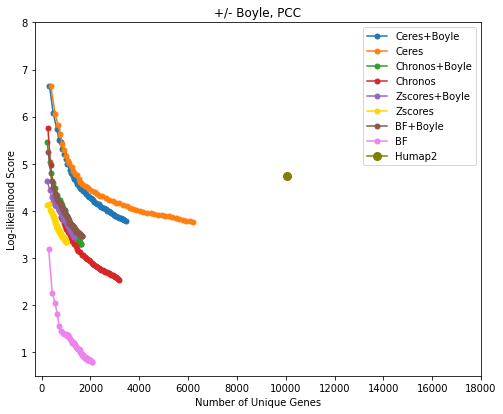

In [8]:
fig, ax= plt.subplots(figsize=(8,6.5))

plt.plot(CleanReactome_LLS_50k_C_Boyle_PCC['numUniqGenes'],CleanReactome_LLS_50k_C_Boyle_PCC['LLS'],marker='o',markersize=5, label='Ceres+Boyle')
plt.plot(CleanReactome_LLS_50k_C_PCC['numUniqGenes'],CleanReactome_LLS_50k_C_PCC['LLS'],marker='o',markersize=5, label='Ceres')

plt.plot(CleanReactome_LLS_50k_CH_Boyle_PCC['numUniqGenes'],CleanReactome_LLS_50k_CH_Boyle_PCC['LLS'],marker='o',markersize=5, label='Chronos+Boyle')
plt.plot(CleanReactome_LLS_50k_CH_PCC['numUniqGenes'],CleanReactome_LLS_50k_CH_PCC['LLS'],marker='o',markersize=5, label='Chronos')

plt.plot(CleanReactome_LLS_50k_Z_Boyle_PCC['numUniqGenes'],CleanReactome_LLS_50k_Z_Boyle_PCC['LLS'],marker='o',markersize=5, label='Zscores+Boyle')
plt.plot(CleanReactome_LLS_50k_Z_PCC['numUniqGenes'],CleanReactome_LLS_50k_Z_PCC['LLS'],marker='o',markersize=5,color='gold', label='Zscores')

plt.plot(CleanReactome_LLS_50k_BF_Boyle_PCC['numUniqGenes'],CleanReactome_LLS_50k_BF_Boyle_PCC['LLS'],marker='o',markersize=5, label='BF+Boyle')
plt.plot(CleanReactome_LLS_50k_BF_PCC['numUniqGenes'],CleanReactome_LLS_50k_BF_PCC['LLS'],marker='o',color='violet',markersize=5, label='BF')

plt.plot(humap_cleanreactome_lls['numUniqGenes'],humap_cleanreactome_lls['LLS'],marker='o',color='olive',markersize=8,label='Humap2')


plt.title('+/- Boyle, PCC')
plt.legend() 
plt.yticks(np.arange(1,9,1))
plt.xticks(np.arange(0,20000,2000))

plt.ylabel('Log-likelihood Score')
plt.xlabel('Number of Unique Genes')
plt.show()


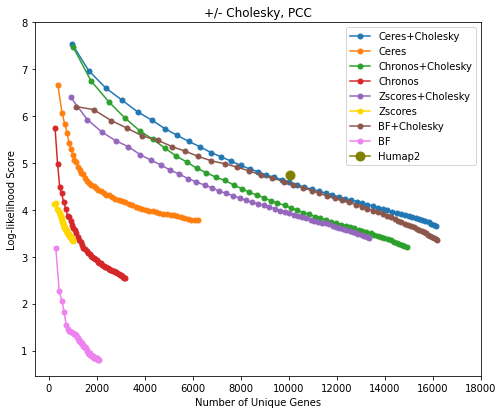

In [9]:
fig, ax= plt.subplots(figsize=(8,6.5))

plt.plot(CleanReactome_LLS_50k_C_Chol_PCC['numUniqGenes'],CleanReactome_LLS_50k_C_Chol_PCC['LLS'],marker='o',markersize=5, label='Ceres+Cholesky')
plt.plot(CleanReactome_LLS_50k_C_PCC['numUniqGenes'],CleanReactome_LLS_50k_C_PCC['LLS'],marker='o',markersize=5, label='Ceres')

plt.plot(CleanReactome_LLS_50k_CH_Chol_PCC['numUniqGenes'],CleanReactome_LLS_50k_CH_Chol_PCC['LLS'],marker='o',markersize=5, label='Chronos+Cholesky')
plt.plot(CleanReactome_LLS_50k_CH_PCC['numUniqGenes'],CleanReactome_LLS_50k_CH_PCC['LLS'],marker='o',markersize=5, label='Chronos')

plt.plot(CleanReactome_LLS_50k_Z_Chol_PCC['numUniqGenes'],CleanReactome_LLS_50k_Z_Chol_PCC['LLS'],marker='o',markersize=5, label='Zscores+Cholesky')
plt.plot(CleanReactome_LLS_50k_Z_PCC['numUniqGenes'],CleanReactome_LLS_50k_Z_PCC['LLS'],marker='o',color='gold',markersize=5, label='Zscores')

plt.plot(CleanReactome_LLS_50k_BF_Chol_PCC['numUniqGenes'],CleanReactome_LLS_50k_BF_Chol_PCC['LLS'],marker='o',markersize=5, label='BF+Cholesky')
plt.plot(CleanReactome_LLS_50k_BF_PCC['numUniqGenes'],CleanReactome_LLS_50k_BF_PCC['LLS'],marker='o',color='violet',markersize=5, label='BF')

plt.plot(humap_cleanreactome_lls['numUniqGenes'],humap_cleanreactome_lls['LLS'],marker='o',color='olive',markersize=9,label='Humap2')

plt.title('+/- Cholesky, PCC')
plt.legend() 
plt.yticks(np.arange(1,9,1))
plt.xticks(np.arange(0,20000,2000))

plt.ylabel('Log-likelihood Score')
plt.xlabel('Number of Unique Genes')
plt.show()


In [18]:
fig, ax= plt.subplots(figsize=(8,6.5))

plt.plot(CleanReactome_LLS_50k_C_Qnorm_PCC['numUniqGenes'],CleanReactome_LLS_50k_C_Qnorm_PCC['LLS'],marker='o',markersize=5, label='Ceres+Qnorm')
plt.plot(CleanReactome_LLS_50k_C_PCC['numUniqGenes'],CleanReactome_LLS_50k_C_PCC['LLS'],marker='o',markersize=5, label='Ceres')

plt.plot(CleanReactome_LLS_50k_CH_Qnorm_PCC['numUniqGenes'],CleanReactome_LLS_50k_CH_Qnorm_PCC['LLS'],marker='o',markersize=5, label='Chronos+Qnorm')
plt.plot(CleanReactome_LLS_50k_CH_PCC['numUniqGenes'],CleanReactome_LLS_50k_CH_PCC['LLS'],marker='o',markersize=5, label='Chronos')

plt.plot(CleanReactome_LLS_50k_Z_Qnorm_PCC['numUniqGenes'],CleanReactome_LLS_50k_Z_Qnorm_PCC['LLS'],marker='o',markersize=5, label='Zscores+Qnorm')
plt.plot(CleanReactome_LLS_50k_Z_PCC['numUniqGenes'],CleanReactome_LLS_50k_Z_PCC['LLS'],marker='o',color='gold',markersize=5, label='Zscores')

plt.plot(CleanReactome_LLS_50k_BF_Qnorm_PCC['numUniqGenes'],CleanReactome_LLS_50k_BF_Qnorm_PCC['LLS'],marker='o',markersize=5, label='BF+Qnorm')
plt.plot(CleanReactome_LLS_50k_BF_PCC['numUniqGenes'],CleanReactome_LLS_50k_BF_PCC['LLS'],marker='o',color='violet',markersize=5, label='BF')

plt.plot(humap_cleanreactome_lls['numUniqGenes'],humap_cleanreactome_lls['LLS'],marker='o',color='olive',markersize=9,label='Humap2')

plt.title('+/- Qnorm, PCC')

plt.legend() 
plt.yticks(np.arange(1,9,1))
plt.xticks(np.arange(0,20000,2000))

plt.ylabel('Log-likelihood Score')
plt.xlabel('Number of Unique Genes')
plt.show()


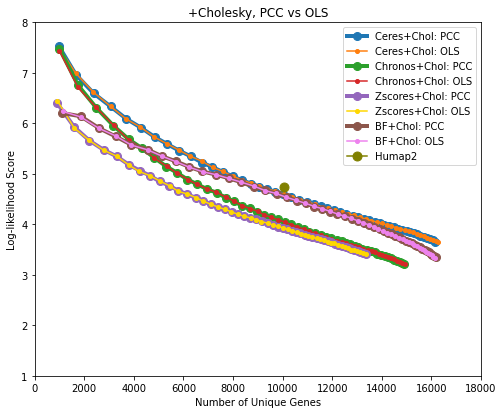

In [11]:
fig, ax= plt.subplots(figsize=(8,6.5))

plt.plot(CleanReactome_LLS_50k_C_Chol_PCC['numUniqGenes'],CleanReactome_LLS_50k_C_Chol_PCC['LLS'],marker='o',linewidth=4,markersize=8, label='Ceres+Chol: PCC')
plt.plot(CleanReactome_LLS_50k_C_Chol_OLS['numUniqGenes'],CleanReactome_LLS_50k_C_Chol_OLS['LLS'],marker='o',linewidth=1.5,markersize=4, label='Ceres+Chol: OLS')

plt.plot(CleanReactome_LLS_50k_CH_Chol_PCC['numUniqGenes'],CleanReactome_LLS_50k_CH_Chol_PCC['LLS'],marker='o',linewidth=4,markersize=8, label='Chronos+Chol: PCC')
plt.plot(CleanReactome_LLS_50k_CH_Chol_OLS['numUniqGenes'],CleanReactome_LLS_50k_CH_Chol_OLS['LLS'],marker='o',linewidth=1.5,markersize=4, label='Chronos+Chol: OLS')

plt.plot(CleanReactome_LLS_50k_Z_Chol_PCC['numUniqGenes'],CleanReactome_LLS_50k_Z_Chol_PCC['LLS'],marker='o',linewidth=4,markersize=8, label='Zscores+Chol: PCC')
plt.plot(CleanReactome_LLS_50k_Z_Chol_OLS['numUniqGenes'],CleanReactome_LLS_50k_Z_Chol_OLS['LLS'],marker='o',linewidth=1.5,markersize=4,color='gold', label='Zscores+Chol: OLS')

plt.plot(CleanReactome_LLS_50k_BF_Chol_PCC['numUniqGenes'],CleanReactome_LLS_50k_BF_Chol_PCC['LLS'],marker='o',linewidth=4,markersize=8, label='BF+Chol: PCC')
plt.plot(CleanReactome_LLS_50k_BF_Chol_OLS['numUniqGenes'],CleanReactome_LLS_50k_BF_Chol_OLS['LLS'],marker='o',color='violet',linewidth=1.5,markersize=4, label='BF+Chol: OLS')

plt.plot(humap_cleanreactome_lls['numUniqGenes'],humap_cleanreactome_lls['LLS'],marker='o',markersize=9,color='olive',label='Humap2')

plt.title('+Cholesky, PCC vs OLS')
plt.legend() 
plt.yticks(np.arange(1,9,1))
plt.xticks(np.arange(0,20000,2000))
plt.ylabel('Log-likelihood Score')
plt.xlabel('Number of Unique Genes')
plt.show()
# 


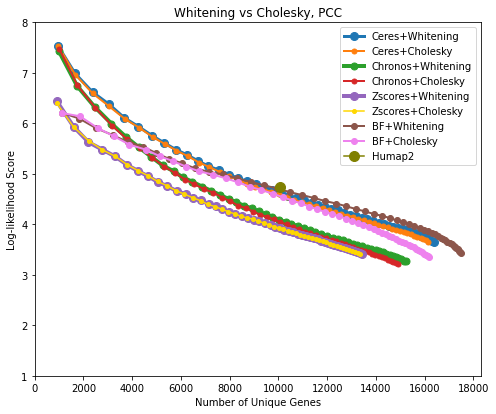

In [12]:
fig, ax= plt.subplots(figsize=(8,6.5))

plt.plot(CleanReactome_LLS_50k_C_White_PCC['numUniqGenes'],CleanReactome_LLS_50k_C_White_PCC['LLS'],marker='o',linewidth=3,markersize=8, label='Ceres+Whitening')
plt.plot(CleanReactome_LLS_50k_C_Chol_PCC['numUniqGenes'],CleanReactome_LLS_50k_C_Chol_PCC['LLS'],marker='o',linewidth=2,markersize=5, label='Ceres+Cholesky')

plt.plot(CleanReactome_LLS_50k_CH_White_PCC['numUniqGenes'],CleanReactome_LLS_50k_CH_White_PCC['LLS'],marker='o',linewidth=4,markersize=7, label='Chronos+Whitening')
plt.plot(CleanReactome_LLS_50k_CH_Chol_PCC['numUniqGenes'],CleanReactome_LLS_50k_CH_Chol_PCC['LLS'],marker='o',linewidth=2,markersize=5, label='Chronos+Cholesky')

plt.plot(CleanReactome_LLS_50k_Z_White_PCC['numUniqGenes'],CleanReactome_LLS_50k_Z_White_PCC['LLS'],marker='o',linewidth=4,markersize=8, label='Zscores+Whitening')
plt.plot(CleanReactome_LLS_50k_Z_Chol_PCC['numUniqGenes'],CleanReactome_LLS_50k_Z_Chol_PCC['LLS'],marker='o',color='gold',linewidth=1.5,markersize=4, label='Zscores+Cholesky')

plt.plot(CleanReactome_LLS_50k_BF_White_PCC['numUniqGenes'],CleanReactome_LLS_50k_BF_White_PCC['LLS'],marker='o',linewidth=2,markersize=6, label='BF+Whitening')
plt.plot(CleanReactome_LLS_50k_BF_Chol_PCC['numUniqGenes'],CleanReactome_LLS_50k_BF_Chol_PCC['LLS'],marker='o',color='violet',linewidth=2,markersize=6, label='BF+Cholesky')

plt.plot(humap_cleanreactome_lls['numUniqGenes'],humap_cleanreactome_lls['LLS'],marker='o',color='olive',markersize=10,label='Humap2')

plt.title('Whitening vs Cholesky, PCC')
plt.legend() 
plt.yticks(np.arange(1,9,1))
plt.xticks(np.arange(0,20000,2000))

plt.ylabel('Log-likelihood Score')
plt.xlabel('Number of Unique Genes')
plt.show()



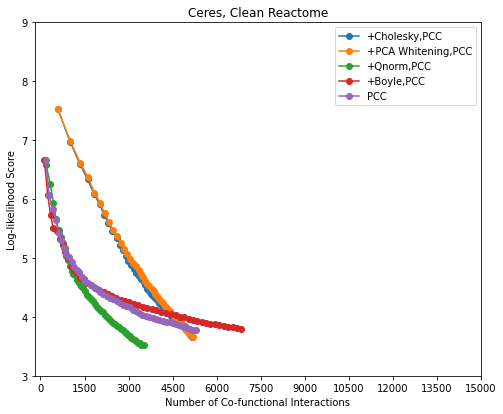

In [16]:
fig, ax= plt.subplots(figsize=(8,6.5))

plt.plot(CleanReactome_LLS_50k_C_Chol_PCC['numPos'],CleanReactome_LLS_50k_C_Chol_PCC['LLS'],marker='o', label='+Cholesky,PCC')
plt.plot(CleanReactome_LLS_50k_C_White_PCC['numPos'],CleanReactome_LLS_50k_C_White_PCC['LLS'],marker='o', label='+PCA Whitening,PCC')

plt.plot(CleanReactome_LLS_50k_C_Qnorm_PCC['numPos'],CleanReactome_LLS_50k_C_Qnorm_PCC['LLS'],marker='o', label='+Qnorm,PCC')
plt.plot(CleanReactome_LLS_50k_C_Boyle_PCC['numPos'],CleanReactome_LLS_50k_C_Boyle_PCC['LLS'],marker='o', label='+Boyle,PCC')
plt.plot(CleanReactome_LLS_50k_C_PCC['numPos'],CleanReactome_LLS_50k_C_PCC['LLS'],marker='o', label='PCC')

plt.title('Ceres, Clean Reactome')
plt.legend() 
plt.yticks(np.arange(3,10,1))
plt.xticks(np.arange(0,16000,1500))
plt.ylabel('Log-likelihood Score')
plt.xlabel('Number of Co-functional Interactions')
plt.show()


In [ ]:
fig, ax= plt.subplots(figsize=(8,6.5))

plt.plot(Reactome_LLS_50k_C_Chol_PCC['numPos'],Reactome_LLS_50k_C_Chol_PCC['LLS'],marker='o', label='+Cholesky,PCC')
plt.plot(Reactome_LLS_50k_C_White_PCC['numPos'],Reactome_LLS_50k_C_White_PCC['LLS'],marker='o', label='+PCA Whitening,PCC')

plt.plot(Reactome_LLS_50k_C_Qnorm_PCC['numPos'],Reactome_LLS_50k_C_Qnorm_PCC['LLS'],marker='o', label='+Qnorm,PCC')
plt.plot(Reactome_LLS_50k_C_Boyle_PCC['numPos'],Reactome_LLS_50k_C_Boyle_PCC['LLS'],marker='o', label='+Boyle,PCC')
plt.plot(Reactome_LLS_50k_C_PCC['numPos'],Reactome_LLS_50k_C_PCC['LLS'],marker='o', label='PCC')

plt.title('Ceres, Full Reactome')
plt.legend() 
plt.xticks(np.arange(0,16000,1500))
plt.yticks(np.arange(3,10,1))
plt.ylabel('Log-likelihood Score')
plt.xlabel('Number of Co-functional Interactions')
plt.show()